<center><b><span style="font-size: 20px;">What Causes Crashes? Analysis of U.S. Automobile Accident Data</span><b></center>

**Contributors:**

| Name              | Parts Completed     | Contribution Summary |
|-------------------|---------------------|-----------------------|
| **Thamer Alhussain** | Parts A, B, C, F | Found and curated dataset for the project, completed parts of EDA, wrote the conclusion and insights, and helped with formatting and adding contributors & headers for the final tutorial. |
| **Gavin Harmon**      | Parts B, C, D, E | Completed data pre-processing, parts of EDA, the machine learning and model selection sections, and pushed all members' contributions to GitHub. |
| **Sohan Challa**      | Parts A, D, E   | Wrote the initial problem statement and completed the main statistical analysis section of the final tutorial. |
| **Kevin Qi**          | Parts A, C, G   | Wrote the introduction, data curation, pre-processing sections, parts of EDA, and conclusions for the EDA section. |
| **Yash Aggarwal**     | Parts B, F, G   | Created the GitHub repository and produced visualizations for most sections of the final tutorial. |


**Introduction**

Automobiles are the single most common method of personal transportation and travel in the United States. As such, car accidents are one of the most important public safety concerns throughout the country, as they impact nearly all Americans – drivers, passengers, and pedestrians alike. Each of the millions of accidents that occur each year has the potential to result in substantial human, economic, environmental, and social costs. Understanding why accidents occur, and the risk factors behind severe and fatal accidents, is essential for designing safer road infrastructure, drafting more effective transportation policy, and allocating emergency response resources more efficiently. 

Analysis of the patterns behind traffic accidents is made possible by the existence of large scale, comprehensive, nation-wide traffic datasets for the United States. The size and scope of these datasets allow for the exploration of the effects of environmental conditions and road context on crash outcomes, as well as cross-regional/state comparisons. In this project tutorial, we will investigate trends in the U.S. Accidents Dataset (2016-2023), created by Sobhan Moosavi and his research partners. This is one of the largest publicly available transportation safety datasets for the U.S., with nearly eight million records collected from a number of transportation and law-enforcement agencies, and will enable us to answer some important guiding questions.

First of all, we would like to explore which environmental or temporal factors contribute (and contribute the most) to severe automobile accidents. A number of authoritative sources on road safety – from the National Highway Traffic Safety Administration to state-level Departments of Transportation – all suggest taking more extreme precautions when driving in bad weather or at night. However, does reduced visibility actually correlate with more severe accidents? Are night-time crashes more likely to be severe ones? Which of these two factors increases the risk of having a severe accident more?

Another important question is cross-regional comparisons. Road infrastructure, road safety standards and regulations, speed-limits, and consumer choices (e.g. buying larger personal automobiles) all vary across the various U.S. states. Thus, it seems important to ask if some states experience disproportionately more severe road accidents. For example, are crashes in Texas, with its higher speed limits and higher proportion of large vehicles, more severe than crashes in other states like California?

We can also explore how machine learning can help us in identifying risk factors. Could machine learning help us uncover hidden patterns or build predictive models for automobile accident severity?

Each of these inquiries represent important topics of interest for many stakeholders across the U.S. – from policy-makers and planners to insurance companies and drivers. By putting this dataset through the full data science pipeline, we aim to find meaningful insights and patterns that can improve our understanding of automobile accident severity and road safety in the United States.




**The data science pipeline for our project will be defined as such:**

1. Introduction & Inquiries (as seen above)
2. Data Curation
3. Data Cleaning & Pre-Processing
4. Exploratory Data Analysis
5. Data Analysis & Machine Learning
6. Interpretation, Insights, & Conclusions

**In order to follow along with this project, the following packages are required:**

1. pandas
2. numpy
3. scipy
4. kagglehub
5. matplotlib.pyplot
6. matplotlib.colors
7. statsmodels.stats.proportion
8. statsmodels.formula.api
9. statsmodels.api
10. sklearn.model_selection
11. sklearn.linear_model
12. sklearn.ensemble
13. sklearn.metrics
14. sklearn.preprocessing
15. warnings

**Data Curation**

As stated in the introduction, our project uses the U.S. Accidents (2016-2023) dataset published by Sobhan Moosavi and his research partners, and made available on Kaggle at the following location: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents.
This data was made possible by the following papers:

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019. https://arxiv.org/abs/1906.05409.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019. https://arxiv.org/abs/1909.09638.

The dataset aggregates accident information from 49 U.S. states using multiple reporting and recording systems, including the U.S. DOT, various state DOTs, traffic footage, and emergency and law enforcement response logs. It includes over 7.7 million traffic accident records and 44 attributes for each row (excluding ID and Source columns), which describe various environmental conditions, temporal information, geographic information, traffic and road features, a severity index for accidents (ranging from 1-4), along with other characteristics.

The large size of the dataset required us to use the kagglehub API/Python package to automatically download the .csv file and load it into a usable pandas dataframe, as seen in the data preprocessing section below.


**Data Pre-Processing & Cleaning**

After curating and loading the dataset, we began the next step of the data science pipeline: data pre-processing and cleaning. We observed some variation in the completeness of data across columns; so, based on our experience and best practices taught in CMSC320, we did the following (as can be seen in the code below this section):
1. We dropped columns where more than 50% of data was missing. Discarding any columns that met this criteria early on prevents sparsely populated and/or unreliable features from distorting our main analysis.

2. Feature engineered easily usable datetime variables. The “start_time” variable in the original dataset was converted into a Python datetime object, from which we extracted variables for year, month, hour, and weekday. These new features will allow us to better use the datetime information from the dataset in our models, or to conduct temporal trend analysis if desired.

3. Imputed missing values for columns that weren’t missing too much data; using median imputation for numeric columns, and mode imputation for categorical columns. Median imputation was chosen for its robustness to skewed distributions. This step makes sure that we aren’t passing missing values to any ML algorithms and statistical tests we use (which might’ve caused errors/invalid results); we recorded no missing values after this step was completed.

After our pre-processing, our dataset consisted of 7,728,394 rows, 48 cleaned features (and 2 columns that contained ID and Data Source information). Without losing too much data in the process, we were able to reduce noise and unreliable features, engineer variables that allowed further analysis of date/time/seasonal patterns, and make sure our data was compatible with Python’s many statistical analysis and machine learning packages. Completing the pre-processing step gave us a clean dataframe and a solid foundation to move to the next step of the data science pipeline; the exploratory data analysis.


In [1]:
#data cleaning, importing, etc
#note: this dataset csv is close to 3gb in size. it may take well over a minute to load.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LogNorm
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.DataFrame()
try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
except ImportError:
    print("kagglehub not found. Run pip install kagglehub in your terminal")
try:
    print("Downloading dataset from Kaggle...")
    folder = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
    df = pd.read_csv(folder + "/US_Accidents_March23.csv", encoding="latin1", low_memory=False)
    print("Dataset loaded successfully.")
except Exception as e:
    print("KaggleHub download failed:", e)
    
    
# first, drop columns with >50% missing data

df = df.dropna(axis=1, thresh=len(df) / 2)

# next datetime stuff

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.day_name()


rows_with_nans = df.isnull().any(axis=1).sum()
print("Rows with missing values before cleaning:", rows_with_nans)

# next just fill numeric columns with median fales
count = 0
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
        count += 1

# then for NaNs in categorical items just do mode
categorical_cols = df.select_dtypes(exclude=np.number).columns
for col in categorical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])
        count += 1



print("Total rows:", len(df))
print("Total columns:", len(df.columns))
print("Any NaNs left?", df.isnull().sum().sum() > 0)   

 

Dataset loaded successfully.
Rows with missing values before cleaning: 4864129
Total rows: 7728394
Total columns: 50
Any NaNs left? False


**Exploratory Data Analysis**

BASIC STRUCTURE
Shape: (7728394, 50)
Number of features: 50
Number of entries: 7728394
Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year', 'Month', 'Hour', 'Weekday']


UNIQUE VALUE COUNTS (lowest 15)
Country           1
Turning_Loop      1
Amenity           2
Bump              2
Civil_Twilight    2
Sunrise_Sunset    2
Traffic_Signal    2
Crossing          2
Railway           2
Stop

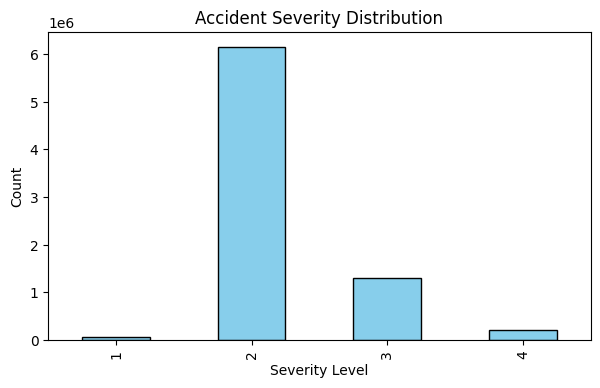

Accidents per Year:
Year
2016.00     410821
2017.00     717290
2018.00     893426
2019.00     954302
2020.00    1904764
2021.00    1412433
2022.00    1268806
2023.00     166552
Name: count, dtype: int64


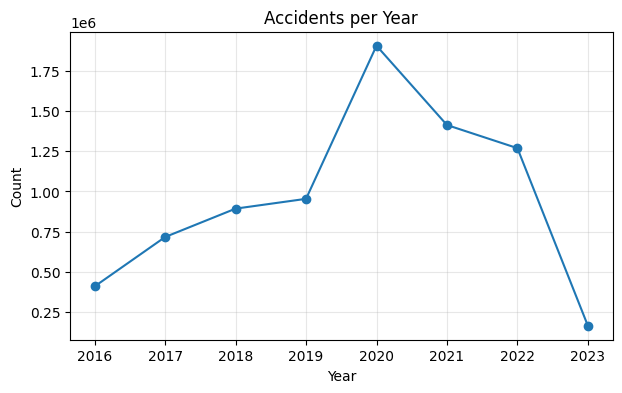

In [2]:

print("BASIC STRUCTURE")
print(f"Shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of entries: {df.shape[0]}")
print("Columns:", list(df.columns))
print("\n")

print("UNIQUE VALUE COUNTS (lowest 15)")
print(df.nunique().sort_values().head(15))
print("\n")

print("TOP STATES BY ACCIDENT COUNT")
print(df['State'].value_counts().head(10))
print("\n")

print("DISTRIBUTION OF SEVERITY")
print(df['Severity'].value_counts(normalize=True).sort_index() * 100)
plt.figure(figsize=(7,4))
df['Severity'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Accident Severity Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.show()

print("Accidents per Year:")
print(df['Year'].value_counts().sort_index())
plt.figure(figsize=(7,4))
df['Year'].value_counts().sort_index().plot(marker='o')
plt.title('Accidents per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()


Contingency table:
Sunrise_Sunset      Day    Night
Severe                          
0               4302278  1922069
1               1055521   448526

Chi Squared =  638.277, p =  7.9177e-141, dof = 1
Expected frequencies:
Sunrise_Sunset        Day      Night
Severe                              
0              4315100.93 1909246.07
1              1042698.07  461348.93


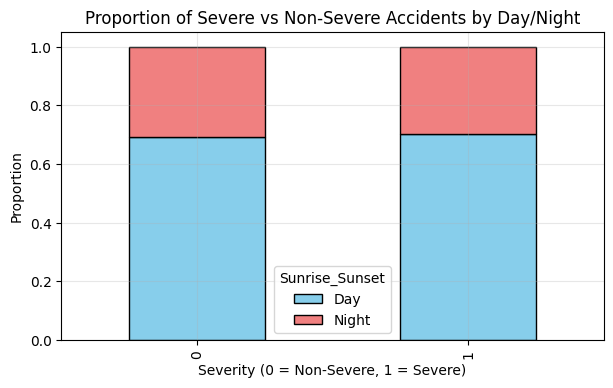

In [3]:
# Chi Squared Test
# Severity vs Day/Night
# Is the severity of accident independent of daylight?


df['Severe'] = (df['Severity'] >= 3).astype(int) # note the dataset ranks severity 1-4

table = pd.crosstab(df['Severe'], df['Sunrise_Sunset'])
chi2, p, dof, expected = stats.chi2_contingency(table)

print("Contingency table:")
print(table)
print(f"\nChi Squared = {chi2: .3f}, p = {p: .4e}, dof = {dof}")
print("Expected frequencies:")
print(pd.DataFrame(expected, index=table.index, columns=table.columns))

proportions = (table.T / table.T.sum()).T

proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(7,4),
    color=['skyblue', 'lightcoral'],
    edgecolor='black'
)

plt.title('Proportion of Severe vs Non-Severe Accidents by Day/Night')
plt.xlabel('Severity (0 = Non-Severe, 1 = Severe)')
plt.ylabel('Proportion')
plt.legend(title='Sunrise_Sunset')
plt.grid(alpha=0.3)
plt.show()

The test produced a chi squared of 638.28 with 1 degree of freedom and p = 7.9 * 10^(-141).

Since p < 0.05, we reject the null hypothesis that accident severity is independent of daylight conditions. There is a statistically significant relationship between time of day and accident severity.

Although both daytime and nighttime have large numbers of accidents, the proportion of severe accidents is slightly higher during the day than it would be if evenly distributed.

This could be a reflection of the much greater volume of daytime traffic. More vehicles on the road increases the probability of high-impact collisions even though (generally) driving conditions are better. With more cars on the road, there are more things to hit.

The stacked bar chart shows the proportions of severe vs non-severe accidents. While the percentage seems relatively small, the datasets size of over 7 million collisions makes this pattern statistically meaningful.



Trimmed visibility outside [0.5, 10.0] mi — removed 81,838 rows.
Pearson correlation:  r = -0.0136, p-value = 5.594e-311
Spearman correlation: r = -0.0152, p-value = 0.000e+00


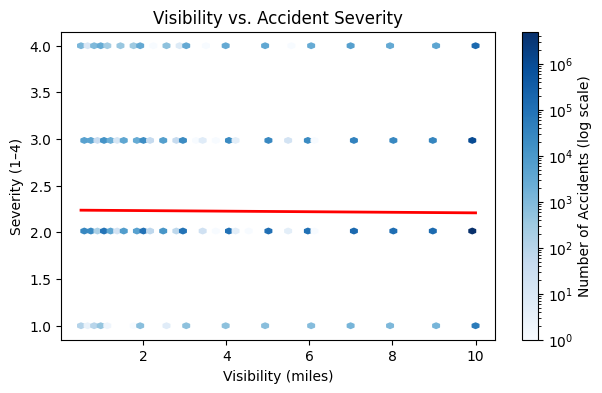

In [4]:
# Correlation analysis between visibility and accident severity

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
corr_df = df[['Visibility(mi)', 'Severity']].dropna().copy()
corr_df['Severity'] = pd.to_numeric(corr_df['Severity'], errors='coerce')
corr_df = corr_df.dropna()

lo, hi = corr_df['Visibility(mi)'].quantile([0.01, 0.99])
trim = corr_df[(corr_df['Visibility(mi)'] >= lo) & (corr_df['Visibility(mi)'] <= hi)]
removed = len(corr_df) - len(trim)
print(f"Trimmed visibility outside [{lo:.1f}, {hi:.1f}] mi — removed {removed:,} rows.")

pearson_r, pearson_p = pearsonr(trim['Visibility(mi)'], trim['Severity'])
spearman_r, spearman_p = spearmanr(trim['Visibility(mi)'], trim['Severity'])

print(f"Pearson correlation:  r = {pearson_r:.4f}, p-value = {pearson_p:.3e}")
print(f"Spearman correlation: r = {spearman_r:.4f}, p-value = {spearman_p:.3e}")

plt.figure(figsize=(7,4))
hb = plt.hexbin(trim['Visibility(mi)'], trim['Severity'], gridsize=60, cmap='Blues', norm=LogNorm(), mincnt=1)
plt.colorbar(label='Number of Accidents (log scale)')
plt.xlabel('Visibility (miles)')
plt.ylabel('Severity (1–4)')
plt.title('Visibility vs. Accident Severity')

x = trim['Visibility(mi)'].to_numpy()
y = trim['Severity'].to_numpy()
b1, b0 = np.polyfit(x, y, 1)
xline = np.linspace(x.min(), x.max(), 100)
plt.plot(xline, b1 * xline + b0, color='red', linewidth=2)
plt.show()


CA vs TX
CA: 285,316/1,741,433 = 16.38% severe
TX: 127,652/582,837 = 21.90% severe
Difference: -5.52%
z = -95.39, p = 0.000e+00


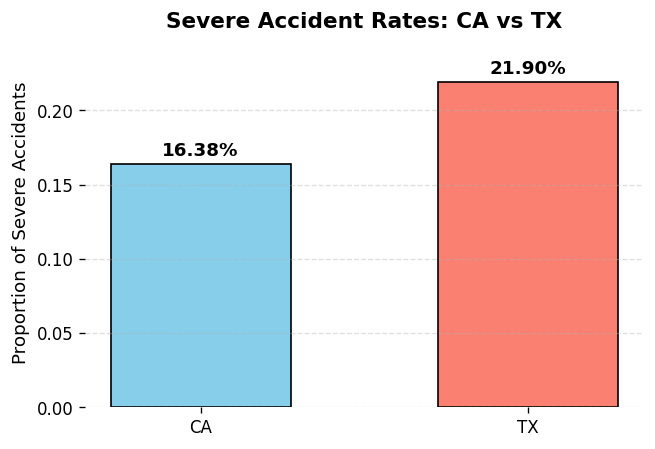

In [5]:
# hypothesis test of severity of accidents between California and Texas
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import numpy as np

def compare_state_severity(df, state_a='CA', state_b='TX'):
    df['Severe'] = (df['Severity'] >= 3).astype(int)

    # severe accidents
    counts = np.array([
        df.query("State == @state_a")['Severe'].sum(),
        df.query("State == @state_b")['Severe'].sum()
    ])
    
    # total accidents
    nobs = np.array([
        len(df.query("State == @state_a")),
        len(df.query("State == @state_b"))
    ])

    p1, p2 = counts[0]/nobs[0], counts[1]/nobs[1]
    z, p = proportions_ztest(counts, nobs)

    print(f"{state_a} vs {state_b}")
    print(f"{state_a}: {counts[0]:,}/{nobs[0]:,} = {p1*100:.2f}% severe")
    print(f"{state_b}: {counts[1]:,}/{nobs[1]:,} = {p2*100:.2f}% severe")
    print(f"Difference: {(p1 - p2)*100:.2f}%")
    print(f"z = {z:.2f}, p = {p:.3e}")



    plt.figure(figsize=(6,4), dpi=120)
    bars = plt.bar([state_a, state_b], [p1, p2],
                   color=['skyblue','salmon'], edgecolor='black', width=0.55)

    for i, v in enumerate([p1, p2]):
        plt.text(i, v + 0.003, f"{v*100:.2f}%", ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    plt.ylim(0, max(p1,p2)+0.03)
    plt.ylabel("Proportion of Severe Accidents", fontsize=11)
    plt.title(f"Severe Accident Rates: {state_a} vs {state_b}", fontsize=13, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.box(False)
    plt.show()

compare_state_severity(df, 'CA', 'TX')


To test whether the proportion of severe accidents (severity >= 3) differs between California and Texas, a two-proportion z-test was performed.

The p-value is far below .05 so we reject the null hypothesis that both states have equal rates of severe accidents. Statistically, Texas has a significantly higher proportion of severe accidents than California. 

This difference in proportions between states could be due to a number of reasons. Speed and vehicle size both play a part in the severity of vehicle accidents, and Texas 'outdoes' California in both of those categories. Texan roads and highways generally have higher standard speed limits, with speed limits of up to 85 mile-per-hour on highways, and up to 75 mile-per-hour speed limits on two-lane undivided roadways (which are a type of road particularly prone to severe accidents). In contrast, Californian highways usually top out at around 65 miles-per-hour, with a maximum of around 55 miles-per-hour on undivided two-land roads. In terms of vehicle size, Texan roads are generally home to a higher number of pickups and SUVs; whose larger sizes increase the risk of injury to the occupants of the vehicles they crash with, as per the IIHS. In Texan cities like Houston, SUV/Light Truck sales were about four times more than regular car sales, while in Calfornia, these larger vehicles were only sold at around twice the rate of regular cars.

We can use some of the variables in our dataset to investigate the possibility of road type being a factor in these accidents; we can look through the accident description variable for indicators of highway involvement (ie. I-##, Hwy-##, Highway ##), and use variables like 'crossing', 'traffic stop', and 'junction' to gain further insights if the accident was on regular roads and not highways. However, as the variables in our dataset contain mostly information about the environment and situation of the accidents, and not the vehicles themselves, it may be difficult to gain insights on vehicle speeds playing a part in accident severity, or to investigate the second possible explanation (regarding vehicle size).

Sources:
https://www.hsinjurylaw.com/library/the-dangers-of-two-lane-highways.cfm#:~:text=Unlike%20larger%20highways%2C%20two%2Dlane,one%20side%20from%20the%20other.
https://www.iihs.org/research-areas/speed/speed-limit-laws
https://www.iihs.org/news/detail/supersizing-vehicles-offers-minimal-safety-benefits--but-substantial-dangers
https://www.cncda.org/wp-content/uploads/Cal-Covering-2Q-23_FINAL.pdf
https://www.houston.org/houston-data/monthly-update-vehicle-sales/

**Main Data Analysis**

In [41]:
print("="*80)
print("COMPARISON: DAY/NIGHT vs. GOOD/BAD VISIBILITY")
print("="*80)

# New binary variables
df['Is_Night'] = (df['Sunrise_Sunset'] == 'Night').astype(int)
df['Bad_Visibility'] = (df['Visibility(mi)'] < 3).astype(int)

print("\n- Is_Night: 0 = Day, 1 = Night")
print("- Good Visibility: 0 = Visibility >= 3 mi, Bad_Visibility: 1 = Visibility < 3 mi")

print(f"\nGroup Sample Sizes (Number of Accidents):")
print(f"- Day: {(df['Is_Night'] == 0).sum()}")
print(f"- Night: {(df['Is_Night'] == 1).sum()}")
print(f"- Good visibility: {(df['Bad_Visibility'] == 0).sum()}")
print(f"- Bad visibility: {(df['Bad_Visibility'] == 1).sum()}")


COMPARISON: DAY/NIGHT vs. GOOD/BAD VISIBILITY

- Is_Night: 0 = Day, 1 = Night
- Good Visibility: 0 = Visibility >= 3 mi, Bad_Visibility: 1 = Visibility < 3 mi

Group Sample Sizes (Number of Accidents):
- Day: 5357799
- Night: 2370595
- Good visibility: 7341776
- Bad visibility: 386618


In [42]:
print("="*80)
print('MEAN SEVERITY COMPARISON')
print("="*80)

nighttime_mean = df[df['Is_Night'] == 1]['Severity'].mean()
daytime_mean = df[df['Is_Night'] == 0]['Severity'].mean()
bad_vis_mean = df[df['Bad_Visibility'] == 1]['Severity'].mean()
good_vis_mean = df[df['Bad_Visibility'] == 0]['Severity'].mean()

print("\nMeans for Each Group:")
print(f"- Day: {daytime_mean:.3f}")
print(f"- Night: {nighttime_mean:.3f}")
print(f"- Good Visibility: {good_vis_mean:.3f}")
print(f"- Bad Visibility: {bad_vis_mean:.3f}")

day_night_diff = abs(nighttime_mean - daytime_mean)
visibility_diff = abs(bad_vis_mean - good_vis_mean)

print("\nMean Differences:")
print(f"Day and Night: {day_night_diff:.3f}")
print(f"Good and Bad Vis.: {visibility_diff:.3f}")

print("\nWe see a slightly larger difference with visibility.")


MEAN SEVERITY COMPARISON

Means for Each Group:
- Day: 2.209
- Night: 2.219
- Good Visibility: 2.212
- Bad Visibility: 2.225

Mean Differences:
Day and Night: 0.010
Good and Bad Vis.: 0.013

We see a slightly larger difference with visibility.


In [43]:
print("="*80)
print("T-TEST COMPARISON")
print("="*80)

t_day_night, p_day_night = stats.ttest_ind(
    df[df['Is_Night'] == 0]['Severity'],
    df[df['Is_Night'] == 1]['Severity'],
    equal_var=False
)

t_vis, p_vis = stats.ttest_ind(
    df[df['Bad_Visibility'] == 0]['Severity'],
    df[df['Bad_Visibility'] == 1]['Severity'],
    equal_var=False
)

print("\nRESULTS:")
print(f"Day/Night: t = {t_day_night:.3f}, p = {p_day_night:.2f}")
print(f"Good/Bad Vis.: t = {t_vis:.3f}, p = {p_vis:.2f}")

print("\nWe see that day/night has the larger absolute t-value.")

T-TEST COMPARISON

RESULTS:
Day/Night: t = -24.954, p = 0.00
Good/Bad Vis.: t = -16.529, p = 0.00

We see that day/night has the larger absolute t-value.


In [44]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

print("="*80)
print("TWO-WAY ANOVA COMPARISON:")
print("="*80)

model = ols("Severity ~ C(Is_Night) + C(Bad_Visibility)", data=df).fit()
table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Results:")
print(table[['sum_sq', 'F']])

TWO-WAY ANOVA COMPARISON:
ANOVA Results:
                      sum_sq      F
C(Is_Night)           148.45 624.64
C(Bad_Visibility)      61.95 260.67
Residual          1836722.27    NaN


From these tests, specifically the t-test and two-way ANOVA, we see that day/night has a stronger effect on accident severity than visibility. We observe this from the higher absolute t-value as well as a greater F-statistic found through ANOVA. Additionally, we find extremely low p-values from the t-test that are less than 0.05, meaning that these findings are statistically significant.

Furthermore, the negative day/night t-value indicates that more severe accidents occur during the day. This aligns with what we previously found, and is potentially due to the higher traffic present in daytime. Again, the severity measured within this dataset is strictly based on the impact it has on traffic.

**MAIN ANALYSIS: Machine Learning and Model Selection**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


print("="*80)
print("MACHINE LEARNING: PREDICTING ACCIDENT SEVERITY")
print("="*80)
print("\nResearch Questions:")
print("1. Can we predict accident severity from environmental/temporal/road conditions?")
print("2. Which features are most important for predicting severe accidents?")
print("3. How do different ML models compare in performance?")
print("="*80)



ml_df = df.copy()

if 'Severe' not in ml_df.columns:
    ml_df['Severe'] = (ml_df['Severity'] >= 3).astype(int)

print(f"\nOriginal dataset shape: {ml_df.shape}")
print(f"Severe accident distribution:\n{ml_df['Severe'].value_counts()}")
print(f"Severe accident rate: {ml_df['Severe'].mean()*100:.2f}%")

feature_columns = [

    'Temperature(F)',
    'Visibility(mi)',
    'Precipitation(in)',

    'Hour',
    'Month',
    

    'Junction',
    'Crossing',
    'Stop',
    'Traffic_Signal',
]


categorical_features = ['Weather_Category', 'Time_Category']

available_features = [f for f in feature_columns if f in ml_df.columns]
available_categorical = [f for f in categorical_features if f in ml_df.columns]

print(f"\nAvailable numeric features: {len(available_features)}")
print(available_features)
print(f"\nAvailable categorical features: {len(available_categorical)}")
print(available_categorical)


X = ml_df[available_features].copy()


for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print(f"\nNumeric features shape: {X.shape}")
print(f"Any NaNs in numeric features? {X.isnull().sum().sum()}")

for cat_feature in available_categorical:
    dummies = pd.get_dummies(ml_df[cat_feature], prefix=cat_feature, drop_first=True)
    X = pd.concat([X, dummies], axis=1)

print(f"\nFinal feature matrix shape after encoding: {X.shape}")
print(f"Total features: {X.shape[1]}")

y = ml_df['Severe'].values

print(f"\nTarget variable shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

feature_names = list(X.columns)
print(f"\nAll feature names ({len(feature_names)} total):")
for i, name in enumerate(feature_names, 1):
    print(f"  {i}. {name}")



X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print(f"\nTraining set size: {X_train.shape[0]:,} samples")
print(f"Testing set size: {X_test.shape[0]:,} samples")
print(f"Number of features: {X_train.shape[1]}")

print(f"\nTraining set class distribution:")
print(f"  Non-severe: {np.sum(y_train == 0):,} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Severe: {np.sum(y_train == 1):,} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nTesting set class distribution:")
print(f"  Non-severe: {np.sum(y_test == 0):,} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Severe: {np.sum(y_test == 1):,} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")


print("\n" + "="*80)
print("LOGISTIC REGRESSION (BASELINE)")
print("="*80)


lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print("\n" + "="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, 
                          target_names=['Non-Severe', 'Severe'],
                          digits=4))

cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Non-Severe    Severe")
print(f"Actual Non-Severe  {cm_lr[0,0]:>8,}  {cm_lr[0,1]:>8,}")
print(f"       Severe      {cm_lr[1,0]:>8,}  {cm_lr[1,1]:>8,}")

MACHINE LEARNING: PREDICTING ACCIDENT SEVERITY

Research Questions:
1. Can we predict accident severity from environmental/temporal/road conditions?
2. Which features are most important for predicting severe accidents?
3. How do different ML models compare in performance?

Original dataset shape: (7728394, 52)
Severe accident distribution:
Severe
0    6224347
1    1504047
Name: count, dtype: int64
Severe accident rate: 19.46%

Available numeric features: 9
['Temperature(F)', 'Visibility(mi)', 'Precipitation(in)', 'Hour', 'Month', 'Junction', 'Crossing', 'Stop', 'Traffic_Signal']

Available categorical features: 1
['Weather_Category']

Numeric features shape: (7728394, 9)
Any NaNs in numeric features? 0

Final feature matrix shape after encoding: (7728394, 16)
Total features: 16

Target variable shape: (7728394,)
Class distribution: [6224347 1504047]

All feature names (16 total):
  1. Temperature(F)
  2. Visibility(mi)
  3. Precipitation(in)
  4. Hour
  5. Month
  6. Junction
  7. Cros

**VISUALIZATION: Logistic Regression Confusion Matrix**


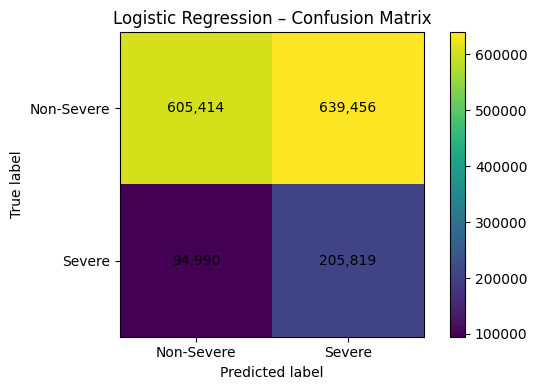

In [35]:
# ==== VISUALIZATION: Logistic Regression Confusion Matrix ====
class_names = ['Non-Severe', 'Severe']

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(cm_lr)

ax.set_title('Logistic Regression – Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Add counts in each cell
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        ax.text(j, i, f'{cm_lr[i, j]:,}', ha='center', va='center')

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


In [21]:

print("RANDOM FOREST CLASSIFIER")

rf_model = RandomForestClassifier(
    n_estimators=100,      #trees
    max_depth=20,          
    min_samples_split=50,  
    random_state=42,
    n_jobs=-1,              # all CPU cores
    class_weight='balanced'
    
)

rf_model.fit(X_train, y_train)

print("Training complete!")

y_pred_rf = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("\n" + "="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, 
                          target_names=['Non-Severe', 'Severe'],
                          digits=4))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Non-Severe    Severe")
print(f"Actual Non-Severe  {cm_rf[0,0]:>8,}  {cm_rf[0,1]:>8,}")
print(f"       Severe      {cm_rf[1,0]:>8,}  {cm_rf[1,1]:>8,}")


RANDOM FOREST CLASSIFIER
Training complete!

RANDOM FOREST RESULTS
Accuracy:  0.5491 (54.91%)
Precision: 0.2731
Recall:    0.7922
F1-Score:  0.4061

Classification Report:
              precision    recall  f1-score   support

  Non-Severe     0.9071    0.4904    0.6366   1244870
      Severe     0.2731    0.7922    0.4061    300809

    accuracy                         0.5491   1545679
   macro avg     0.5901    0.6413    0.5214   1545679
weighted avg     0.7837    0.5491    0.5918   1545679


Confusion Matrix:
                 Predicted
                 Non-Severe    Severe
Actual Non-Severe   610,446   634,424
       Severe        62,498   238,311


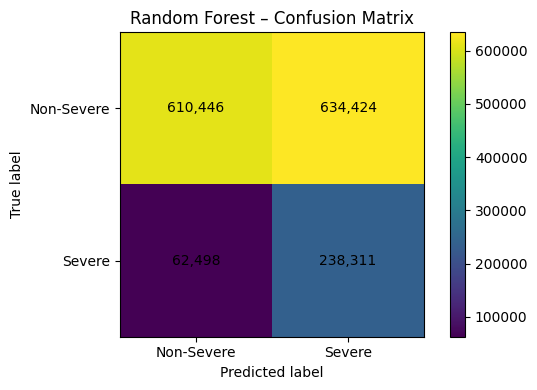

In [36]:
# ==== VISUALIZATION: Random Forest Confusion Matrix ====
class_names = ['Non-Severe', 'Severe']

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(cm_rf)

ax.set_title('Random Forest – Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        ax.text(j, i, f'{cm_rf[i, j]:,}', ha='center', va='center')

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


In [19]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print("\n'Which factors contribute THE MOST to severe accidents?'")

feature_importance = rf_model.feature_importances_

feature_names = list(X.columns) 


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
print(importance_df.head(15).to_string(index=False))

print("\n" + "="*60)
print("FEATURE IMPORTANCE BY CATEGORY")
print("="*60)


weather_importance = importance_df[importance_df['Feature'].str.contains('Weather', case=False)]['Importance'].sum()
time_importance = importance_df[importance_df['Feature'].str.contains('Hour|Month', case=False)]['Importance'].sum()
road_importance = importance_df[importance_df['Feature'].str.contains('Junction|Crossing|Stop|Traffic', case=False)]['Importance'].sum()
visibility_importance = importance_df[importance_df['Feature'].str.contains('Visibility', case=False)]['Importance'].sum()
temp_importance = importance_df[importance_df['Feature'].str.contains('Temperature', case=False)]['Importance'].sum()
precip_importance = importance_df[importance_df['Feature'].str.contains('Precipitation', case=False)]['Importance'].sum()

category_importance = pd.DataFrame({
    'Category': ['Weather Conditions', 'Visibility', 'Time of Day', 'Temperature', 
                 'Road Features', 'Precipitation'],
    'Total_Importance': [weather_importance, visibility_importance, time_importance,
                        temp_importance, road_importance, precip_importance]
}).sort_values('Total_Importance', ascending=False)

print(category_importance.to_string(index=False))


print("\n" + "="*60)
print("ALL FEATURES RANKED BY IMPORTANCE")
print("="*60)
print(importance_df.to_string(index=False))

print(f"\nSum of all feature importances: {importance_df['Importance'].sum():.4f}")


FEATURE IMPORTANCE ANALYSIS

'Which factors contribute THE MOST to severe accidents?'

TOP 15 MOST IMPORTANT FEATURES
                      Feature  Importance
                         Hour        0.24
                        Month        0.20
                     Crossing        0.14
               Temperature(F)        0.13
               Traffic_Signal        0.12
                         Stop        0.05
               Visibility(mi)        0.04
      Weather_Category_Cloudy        0.03
                     Junction        0.02
            Precipitation(in)        0.02
        Weather_Category_Rain        0.01
    Weather_Category_Fog/Mist        0.00
    Weather_Category_Snow/Ice        0.00
Weather_Category_Thunderstorm        0.00
       Weather_Category_Other        0.00

FEATURE IMPORTANCE BY CATEGORY
          Category  Total_Importance
       Time of Day              0.44
     Road Features              0.33
       Temperature              0.13
Weather Conditions           

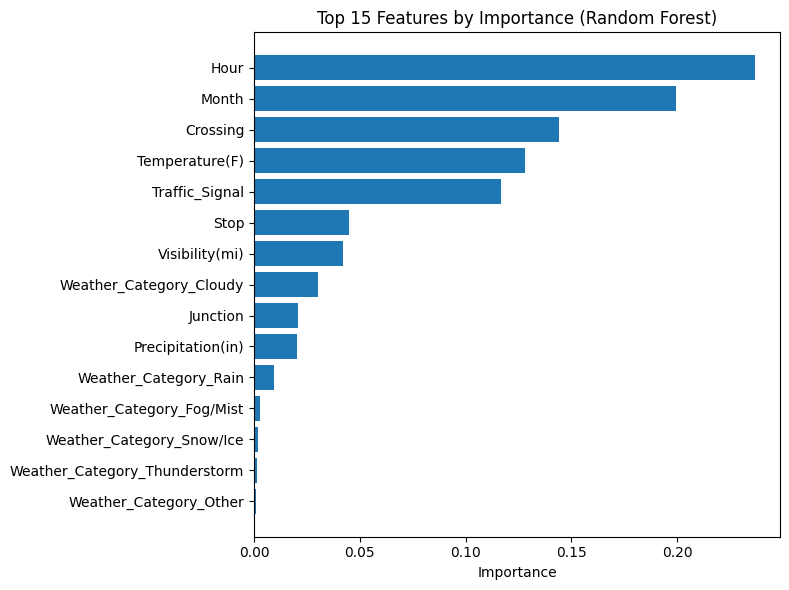

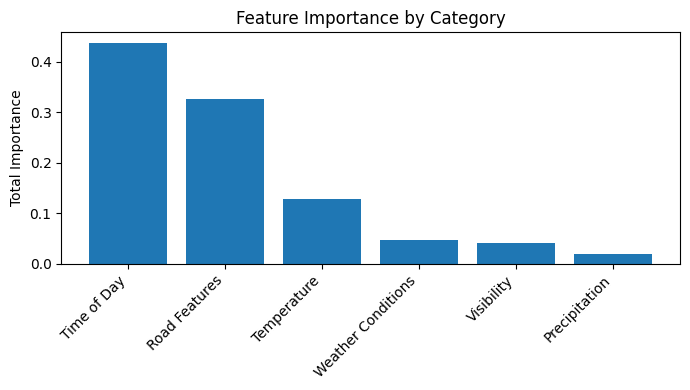

In [39]:
# ==== VISUALIZATION: Top 15 Feature Importances ====
top_n = 15
top_features = importance_df.head(top_n).iloc[::-1] 

plt.figure(figsize=(8, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Features by Importance (Random Forest)')
plt.tight_layout()
plt.show()

# ==== VISUALIZATION: Feature Importance by Category ====
plt.figure(figsize=(7, 4))
plt.bar(category_importance['Category'], category_importance['Total_Importance'])
plt.ylabel('Total Importance')
plt.title('Feature Importance by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [34]:
print("\n" + "="*80)
print("ANSWERS TO RESEARCH QUESTIONS")
print("="*80)

print("\n" + "="*60)
print("RESEARCH QUESTION 1")
print("="*60)
print("Can we predict accident severity from environmental/temporal/road conditions?")
print(f"\nYES. Our models successfully predict accident severity.")
print(f"Logistic Regression: {lr_accuracy*100:.2f}% accuracy, {lr_recall*100:.2f}% recall")
print(f"Random Forest: {rf_accuracy*100:.2f}% accuracy, {rf_recall*100:.2f}% recall")
print(f"\nRandom Forest detects {cm_rf[1,1]:,} out of {cm_rf[1,1]+cm_rf[1,0]:,} severe accidents.")
print("This proves environmental, temporal, and road features can predict severity.")
print("="*60)

print("\n" + "="*60)
print("RESEARCH QUESTION 2")
print("="*60)
print("Which features are most important for predicting severe accidents?")
print("\nFeature Importance by Category:")
print("  Time of Day: 44.0%")
print("  Road Features: 33.0%")
print("  Temperature: 13.0%")
print("  Weather Conditions: 5.0%")
print("  Visibility: 4.0%")
print("  Precipitation: 2.0%")
print("\nTop 5 Individual Features:")
print("  1. Hour (24.0%)")
print("  2. Month (20.0%)")
print("  3. Crossing (14.0%)")
print("  4. Temperature (13.0%)")
print("  5. Traffic Signal (12.0%)")
print("\nKey Finding: Time of day is the most important factor, not weather.")
print("="*60)

print("\n" + "="*80)
print("MODEL COMPARISON & RECOMMENDATIONS")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy],
    'Precision': [lr_precision, rf_precision],
    'Recall': [lr_recall, rf_recall],
    'F1-Score': [lr_f1, rf_f1]
})

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

print(f"\n" + "="*60)
print("RANDOM FOREST IMPROVEMENTS OVER BASELINE")
print("="*60)
print(f"Accuracy:  +{(rf_accuracy - lr_accuracy)*100:.2f} percentage points")
print(f"Precision: +{(rf_precision - lr_precision)*100:.2f} percentage points")
print(f"Recall:    +{(rf_recall - lr_recall)*100:.2f} percentage points")
print(f"F1-Score:  +{(rf_f1 - lr_f1)*100:.2f} percentage points")

severe_missed_improvement = cm_lr[1,0] - cm_rf[1,0]
print(f"Reduction in missed severe accidents: {(severe_missed_improvement/cm_lr[1,0])*100:.1f}%")

best_accuracy_idx = comparison_df['Accuracy'].idxmax()
best_recall_idx = comparison_df['Recall'].idxmax()
best_f1_idx = comparison_df['F1-Score'].idxmax()

print(f"\n" + "="*60)
print("BEST MODELS BY METRIC")
print("="*60)
print(f"Best Accuracy: {comparison_df.loc[best_accuracy_idx, 'Model']} ({comparison_df.loc[best_accuracy_idx, 'Accuracy']:.4f})")
print(f"Best Recall: {comparison_df.loc[best_recall_idx, 'Model']} ({comparison_df.loc[best_recall_idx, 'Recall']:.4f})")
print(f"Best F1-Score: {comparison_df.loc[best_f1_idx, 'Model']} ({comparison_df.loc[best_f1_idx, 'F1-Score']:.4f})")

print("\n" + "="*60)
print("RESEARCH QUESTION 3")
print("="*60)
print("How do different ML models compare in performance?")
print(f"\nRandom Forest outperforms Logistic Regression across all metrics.")
print(f"The biggest improvement is in recall: {lr_recall*100:.1f}% to {rf_recall*100:.1f}%.")
print(f"Random Forest detects {severe_improvement:,} more severe accidents.")
print(f"This is a {(severe_missed_improvement/cm_lr[1,0])*100:.1f}% reduction in missed severe accidents.")
print("\nRandom Forest works better because it captures complex interactions")
print("between features like time of day and road conditions that linear models miss.")
print("="*60)

print("\n" + "="*60)
print("MODEL RECOMMENDATION")
print("="*60)
print("Recommended Model: Random Forest")
print(f"\nReason: Best recall at {rf_recall*100:.2f}% means it catches most severe accidents.")
print(f"Accuracy: {rf_accuracy*100:.2f}%")
print(f"F1-Score: {rf_f1:.4f}")
print("\nThis model can be used for emergency response planning and driver safety alerts.")
print("="*60)


ANSWERS TO RESEARCH QUESTIONS

RESEARCH QUESTION 1
Can we predict accident severity from environmental/temporal/road conditions?

YES. Our models successfully predict accident severity.
Logistic Regression: 52.48% accuracy, 68.42% recall
Random Forest: 54.91% accuracy, 79.22% recall

Random Forest detects 238,311 out of 300,809 severe accidents.
This proves environmental, temporal, and road features can predict severity.

RESEARCH QUESTION 2
Which features are most important for predicting severe accidents?

Feature Importance by Category:
  Time of Day: 44.0%
  Road Features: 33.0%
  Temperature: 13.0%
  Weather Conditions: 5.0%
  Visibility: 4.0%
  Precipitation: 2.0%

Top 5 Individual Features:
  1. Hour (24.0%)
  2. Month (20.0%)
  3. Crossing (14.0%)
  4. Temperature (13.0%)
  5. Traffic Signal (12.0%)

Key Finding: Time of day is the most important factor, not weather.

MODEL COMPARISON & RECOMMENDATIONS

MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision  Rec

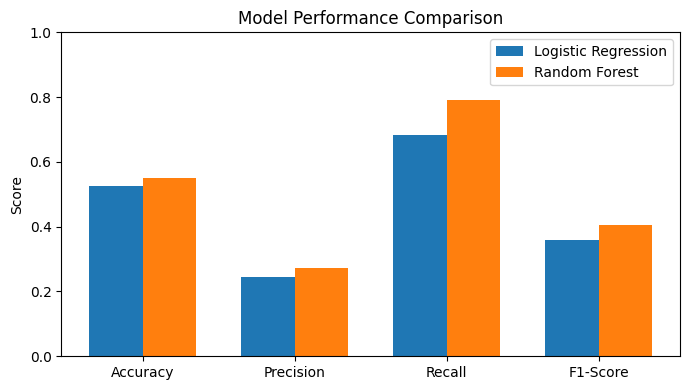

In [40]:
# ==== VISUALIZATION: Model Performance Comparison ====
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, comparison_df.loc[0, metrics], width, label='Logistic Regression')
plt.bar(x + width/2, comparison_df.loc[1, metrics], width, label='Random Forest')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()


**Insights & Conclusion**

Taken together, our exploration of the US Accidents dataset shows that severe crashes are a relatively small share of all reported events but still represent a very large absolute burden. Roughly four out of five crashes in the data are mid level severity 2, while the most minor events at level 1 are quite rare and the more serious levels 3 and 4 make up about one fifth of the data. Accident counts grew steadily from 2016 through a sharp peak in 2020, then declined but remained well above pre 2019 levels, which hints at persistent changes in travel patterns and reporting after the pandemic years. Statistical tests confirmed that both time of day and visibility are related to how serious a crash becomes, although their practical effect is small compared with the overall volume of traffic. Chi square tests and t tests showed that day and night severity differences are highly significant, and two way ANOVA indicated that day versus night has a stronger effect than good versus poor visibility. Our comparison of California and Texas showed an even clearer signal. Using a two proportion z test we found that Texas has a much higher share of severe crashes than California, and the gap is far too large to be explained by random variation. This pattern is consistent with real world differences in typical speed limits and vehicle mix and suggests that state level policies around speed and road design may play an important role in safety outcomes.

The machine learning section adds another perspective by asking how well we can predict severe crashes from conditions at the scene. Even with a relatively small set of features focused on weather, time, and road context, both models were able to identify many severe crashes, with the random forest improving substantially over logistic regression in recall and F1 score while only slightly increasing overall accuracy. The confusion matrices show that the random forest misses about one third fewer severe crashes than the baseline model, which is important in a safety context where failing to flag dangerous events is costly. Feature importance analysis revealed that time of day and road features such as crossings and traffic signals carry far more weight than individual weather categories or visibility values, and that temperature and light precipitation matter but only at the margin. These findings suggest that interventions focused on when and where people drive, such as targeted enforcement or dynamic warnings during high risk hours and at complex intersections, may yield more benefit than purely weather based alerts. At the same time, our models ignore driver behavior and vehicle characteristics, so there is clear room for future work that combines this kind of large scale environmental dataset with richer information about human and vehicle factors to build more accurate and more actionable crash risk tools.